https://www.kaggle.com/code/alaawaelmo/youtube-comments-spam-detection/notebook#Import-Libraries

Dataset: https://github.com/mansipatel12/CS6348Project/blob/main/modified_spam.csv


# Without oversampling

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import spacy
import re
nlp=spacy.load('en_core_web_sm')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

In [ ]:
# Read the file manually, treating it as raw text
with open("/content/modified_spam.csv", "r", encoding="utf-8") as input_file:
    lines = input_file.readlines()

# Skip the header row
lines = lines[1:]


In [ ]:

# Process each line by splitting at the first comma
dataset = []
for line in lines:
    # Split at the first comma only
    parts = line.strip().split(",", 1)
    # Ensure valid split
    if len(parts) == 2:
        dataset.append(parts)
    else:
        # Handle missing messages
        dataset.append([parts[0], ""])


In [ ]:

# Create a dataframe with the dataset; create two columns for label and message
dataframe = pd.DataFrame(dataset, columns=["label", "message"])
# Map ham = 0 and spam = 1in the label
dataframe['label'] = dataframe['label'].map({'ham': 0, 'spam': 1})



In [ ]:

# Drop rows that have NaN or inf as labels
 # Remove NaN values
dataframe = dataframe[~dataframe['label'].isna()]
# Remove inf laebls
dataframe = dataframe[~dataframe['label'].apply(np.isinf)]

dataframe['label'] = dataframe['label'].astype(int)


In [ ]:

# Print first 20 rows
dataframe.head(20)


,label,message
0,1,Free entry in 2 a wkly comp to win FA Cup fina...
1,1,FreeMsg Hey there darling it's been 3 week's n...
2,1,WINNER!! As a valued network customer you have...
3,1,Had your mobile 11 months or more? Update to l...
4,1,SIX chances to win CASH! From 100 to 20000 pou...
5,1,URGENT! You have won a 1 week FREE membership ...
6,1,XXXMobileMovieClub: To use your credit click h...
7,1,England v Macedonia - don't miss goals/team ne...
8,1,Thanks for your subscription to Ringtone UK. P...
9,1,Rodger Burns - MSG: Claim your free Nokia mobi...


In [ ]:
value_counts = dataframe['label'].value_counts()
value_counts

,count
label,
0,4825
1,747


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stop_words=['music','youtube','video','i','u', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"'so', 'keep', 'when', "'m", 'do', 'either', 'them', 'whence', 'with', 'put', '‘ve', 'on', 'your', 'becoming', 'whereby', 'whose', 'each', 'amount', 'me', 'fifteen', 'mostly', 'show', 'would', 'next',  'there', 'nothing', 'she', 'but', 'for', 'here', 'why', 'these', 'further', 'between', 'eleven', 'than', 'am', 'beside', 'after', 'under', 'if','around', 'have', 'such', 'less', 'her', 'before', 'although', 'has', 'among', 'amongst', 'least', '’re', 'should', 'fifty', 'last', 'off', 'formerly', 'until', 'much', 'this', '’ll', 'get', 'perhaps', 'how', 'eight', 'any', 'indeed', 'you', 'myself', 'neither', 'seeming', 'beforehand', 'it', 'thru', 'out', 'call', 'forty', 'one', 'still', 'whereupon', 'wherever', 'over', 'also', 'former', 'namely', 'been', 'make', 'doing', 'regarding', 'he', 'due', 'other', 'bottom', 'sometimes', 'a', 'moreover', 'though', 'whether', 'seemed', 'too', "'re", 'could', 'part', 'everything', 'by', 'thus', 'anyway', 'into', 'go', 'nevertheless', 'anyhow', 'within', 'whoever', 'third', 'being', 'various', 'wherein', 'at', 'take', 'thereby', 'does', 'nine','what', 'almost', 'ever', 'my', 'name', 'yours', 'hereby', 'say', 'hereupon', 'and', 'twelve', 'becomes', 'about', 'own', '’m', 'beyond', 'just', 'above', 'full', 'very', 'besides', 'had', 'noone', 'anything', 'both', 'down', 'whenever', 'several', 'afterwards', 'are',  'because', 'might', 'upon', 'quite', 'done', 'to', 'top', 'really', 'were', 'across', 'yourself', 'others', 'only', 'anywhere', 'move', 'whatever', 'their', 'therein', 'everyone', 'everywhere', 'now', 'something', 'toward', 'however', 'see', 'alone', "'s", '’ve', 'its', 'back', 'our', 'itself', '’d', 'every', 'thereafter', 'whom', 'already', 'as', 'hers', 'where','behind', 'in', 'therefore', 'used', 'together', 'hereafter', 'ca', 'mine', 'many', 'else', 'onto', 'since', '’s', 'whither', 'somewhere', 'themselves', 'from', 'otherwise', 'sixty', 'twenty', 'is', 'two', 'towards', '‘s', 'ten', 'they', 'please', 'those', 'did',  'hundred', 'again', 'became', 'made', 'who', '‘re', 'herein', 'same', 'front', 'up', 'whereas', 'along', 'three', 'then', 'which', 'rather', 'via', 'empty', 'hence', 'seems', 'seem', 'was', 'well', 'meanwhile', 'someone', 'elsewhere', 'once', '‘d', 'the', 'latterly', 'using', 'sometime', 'some', 'whereafter', 'six', 'while', 'of', "'d", 'first', 'herself', 'us', 'be', 'we', 'become', 'often', 'i', 'all', 'another', 'side', 'five', '‘m',  'four', 'must', 'him','somehow', 'serious', "'ll", 'or', 'none', 'during', 'can', 'thence', 'through', 're', 'that', '‘ll', 'his', "'ve", 'throughout', 'always', 'may', 'give', 'will', 'whole', 'yourselves', 'latter', 'ourselves', 'nowhere', 'thereupon', 'an', 'per', 'ours','day','much']

In [ ]:
stop_words=set(stop_words)

In [ ]:
def clean_text(text):
  text=text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text = re.sub(r'\@\w+|\#','', text)
  text = re.sub(r'[^\x00-\x7F]+','', text)
  text=re.sub(r'[^a-zA-Z0-9\s]','',text)
  text=re.sub(r'\s+https\S+',' ',text)
  text=re.sub(r'\s+www\S+',' ',text)
  text=re.sub(r'\s+http\S+',' ',text)
  text=re.sub(r'\s+',' ',text)
  text=re.sub(r'\d+','',text)
  text=text.strip()
  words = nlp(text)
  words = [word.lemma_ for word in words]
  words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
  return ' '.join(words)

In [ ]:

dataframe['message']=dataframe['message'].apply(clean_text)

In [ ]:
x=dataframe['message']
y=dataframe['label']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       952
           1       0.99      0.85      0.91       163

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



<Axes: >

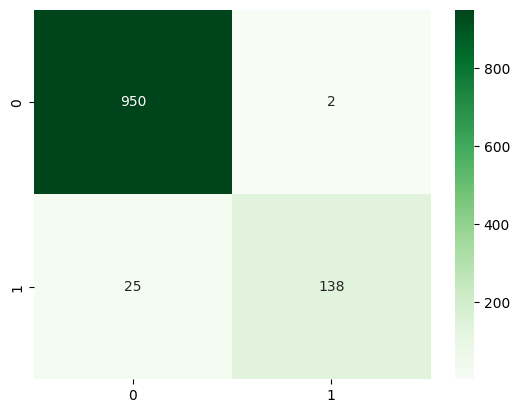

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=Pipeline([('tfidf',TfidfVectorizer()),('RandomForestClassifier',RandomForestClassifier(random_state=43))])
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='', cmap='Greens')

In [ ]:
acc=[]
names=['RandomForest']
acc.extend([rf.score(x_test,y_test)])
acc

[0.9757847533632287]

## Testing

In [ ]:
spam_text=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]

In [ ]:
not_spam_text=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]

In [ ]:
spam_text=[clean_text(sent) for sent in spam_text ]
not_spam_text=[clean_text(sent) for sent in not_spam_text ]

In [ ]:
not_spam_text

['love eminem',
 'think million view come people want check view',
 'psy gangnam style thumb check view']

In [ ]:
spam_text

['week click find',
 'amazing check page similar content',
 'love sub sub',
 'fire check channel']

In [ ]:
pred = rf.predict(spam_text)
for i in range(len(spam_text)):
    if pred[i] < 0.5:
        print('Not Spam')
    else:
        print('Spam')

Not Spam
Not Spam
Not Spam
Not Spam


In [ ]:
pred = rf.predict(not_spam_text)
for i in range(len(not_spam_text)):
    if pred[i] < 0.5:
        print('Not Spam')
    else:
        print('Spam')

Not Spam
Spam
Spam


# With Oversampling


## SMOTE (Synthetic Minority Oversampling Technique)






In [ ]:
# First, add these imports at the top of your file
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline


In [ ]:
rf_pipeline = make_imb_pipeline(
    TfidfVectorizer(),
    SMOTE(random_state=42),  # Add SMOTE here
    RandomForestClassifier(random_state=43)
)


In [ ]:
rf_pipeline.fit(x_train, y_train)
y_pred = rf_pipeline.predict(x_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       952
           1       1.00      0.88      0.93       163

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



<Axes: >

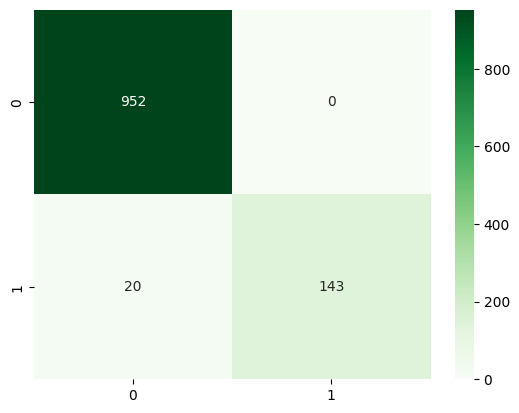

In [ ]:
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap='Greens')


In [ ]:
acc = []
names = ['RandomForest with SMOTE']
acc.extend([rf_pipeline.score(x_test, y_test)])
print(acc)

[0.9820627802690582]


## Testing

In [ ]:
spam_text=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]

In [ ]:
not_spam_text=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]

In [ ]:
spam_text=[clean_text(sent) for sent in spam_text ]
not_spam_text=[clean_text(sent) for sent in not_spam_text ]

In [ ]:
not_spam_text

['love eminem',
 'think million view come people want check view',
 'psy gangnam style thumb check view']

In [ ]:
spam_text

['week click find',
 'amazing check page similar content',
 'love sub sub',
 'fire check channel']

In [ ]:
pred = rf_pipeline.predict(spam_text)
for i in range(len(spam_text)):
    if pred[i] < 0.5:
        print(f'Text: "{spam_text[i]}" \nPrediction: Not Spam\n')
    else:
        print(f'Text: "{spam_text[i]}" \nPrediction: Spam\n')

Text: "week click find" 
Prediction: Not Spam

Text: "amazing check page similar content" 
Prediction: Not Spam

Text: "love sub sub" 
Prediction: Not Spam

Text: "fire check channel" 
Prediction: Not Spam



In [ ]:
pred = rf_pipeline.predict(not_spam_text)
for i in range(len(not_spam_text)):
    if pred[i] < 0.5:
        print(f'Text: "{not_spam_text[i]}" \nPrediction: Not Spam\n')
    else:
        print(f'Text: "{not_spam_text[i]}" \nPrediction: Spam\n')

Text: "love eminem" 
Prediction: Not Spam

Text: "think million view come people want check view" 
Prediction: Not Spam

Text: "psy gangnam style thumb check view" 
Prediction: Spam



## ADASYN (Adaptive Synthetic Sampling)

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline as make_imb_pipeline


In [ ]:
adasynpipeline = make_imb_pipeline(
    TfidfVectorizer(),
    ADASYN(random_state=42),
    RandomForestClassifier(random_state=43)
)

In [ ]:
adasynpipeline.fit(x_train, y_train)
y_pred = adasynpipeline.predict(x_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       952
           1       1.00      0.88      0.93       163

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



<Axes: >

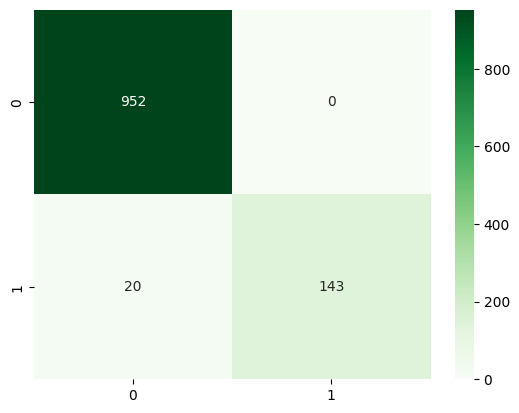

In [ ]:
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap='Greens')


In [ ]:
acc = []
names = ['RandomForest with SMOTE']
acc.extend([adasynpipeline.score(x_test, y_test)])
print(acc)

[0.9820627802690582]


## Testing

In [ ]:
spam_text=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]

In [ ]:
not_spam_text=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]

In [ ]:
spam_text=[clean_text(sent) for sent in spam_text ]
not_spam_text=[clean_text(sent) for sent in not_spam_text ]

In [ ]:
not_spam_text

['love eminem',
 'think million view come people want check view',
 'psy gangnam style thumb check view']

In [ ]:
spam_text

['week click find',
 'amazing check page similar content',
 'love sub sub',
 'fire check channel']

In [ ]:
pred = adasynpipeline.predict(spam_text)
for i in range(len(spam_text)):
    if pred[i] < 0.5:
        print(f'Text: "{spam_text[i]}" \nPrediction: Not Spam\n')
    else:
        print(f'Text: "{spam_text[i]}" \nPrediction: Spam\n')

Text: "week click find" 
Prediction: Not Spam

Text: "amazing check page similar content" 
Prediction: Not Spam

Text: "love sub sub" 
Prediction: Not Spam

Text: "fire check channel" 
Prediction: Not Spam



In [ ]:
pred = adasynpipeline.predict(not_spam_text)
for i in range(len(not_spam_text)):
    if pred[i] < 0.5:
        print('Not Spam')
    else:
        print('Spam')

Not Spam
Not Spam
Spam


# Removing few common stop words + With Oversampling + With GridSearch

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:


# Read the file manually, treating it as raw text
with open("/content/modified_spam.csv", "r", encoding="utf-8") as input_file:
    lines = input_file.readlines()

# Skip the header row
lines = lines[1:]

# Process each line by splitting at the first comma
dataset = []
for line in lines:
    # Split at the first comma only
    parts = line.strip().split(",", 1)
    # Ensure valid split
    if len(parts) == 2:
        dataset.append(parts)
    else:
        # Handle missing messages
        dataset.append([parts[0], ""])


In [23]:



# Create a dataframe with the dataset; create two columns for label and message
dataframe = pd.DataFrame(dataset, columns=["label", "message"])
# Map ham = 0 and spam = 1in the label
dataframe['label'] = dataframe['label'].map({'ham': 0, 'spam': 1})


In [24]:

# Drop rows that have NaN or inf as labels
 # Remove NaN values
dataframe = dataframe[~dataframe['label'].isna()]
# Remove inf laebls
dataframe = dataframe[~dataframe['label'].apply(np.isinf)]

dataframe['label'] = dataframe['label'].astype(int)


In [26]:
# Text cleaning function (without stopword removal - we'll let TF-IDF handle it)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'\s+',' ', text).strip()
    return text

In [28]:
dataframe['message'] = dataframe['message'].apply(clean_text)


In [29]:
x=dataframe['message']
y=dataframe['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


In [30]:
# Pipeline with SMOTE and TF-IDF using built-in stop words
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Using built-in English stop words
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

In [64]:
# Parameter grid for GridSearch
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__use_idf': [True, False],
    'clf__n_estimators': [100],
    'clf__max_depth': [None]
}

In [65]:
# GridSearch with F1-score optimization
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

In [66]:
print("Starting Grid Search...")
grid_search.fit(x_train, y_train)
print("Grid Search Complete!")

Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid Search Complete!


In [37]:
# # Mini test run (remove after testing)
# mini_param_grid = {
#     'tfidf__max_features': [5000],
#     'tfidf__ngram_range': [(1,1)],
#     'clf__n_estimators': [50],  # Fewer trees
#     'clf__max_depth': [None]
# }
# mini_search = GridSearchCV(pipeline, mini_param_grid, cv=3, n_jobs=-1)
# mini_search.fit(x_train[:1000], y_train[:1000])  # Small data subset



# classified everything as not spam

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None], 'clf__n_estimators': [50],
                         'tfidf__max_features': [5000],
                         'tfidf__ngram_range': [(1, 1)]})

In [67]:
# Best model evaluation
best_model = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")


Best Parameters:
clf__max_depth: None
clf__n_estimators: 100
tfidf__max_features: 5000
tfidf__ngram_range: (1, 1)
tfidf__use_idf: True


In [68]:

# Evaluation
y_pred = best_model.predict(x_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       952
           1       0.98      0.90      0.94       163

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115




Confusion Matrix:


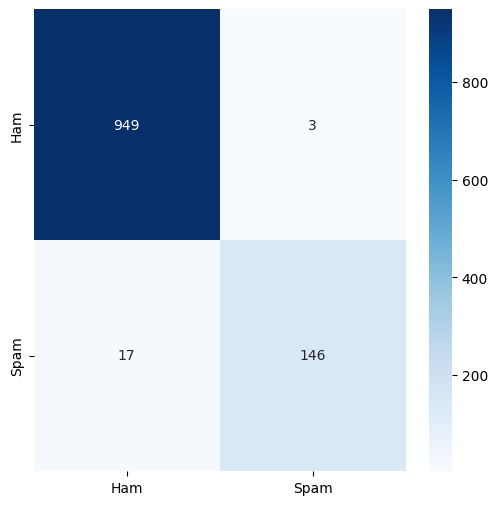

In [69]:
print("\nConfusion Matrix:")
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.show()


In [79]:
# Test on sample messages
test_msgs = [
    "WINNER!! Claim your prize now! Text YES to 4455",
    "Hey, can we reschedule for tomorrow?",
    "URGENT: Your account needs verification",
    "Lunch tomorrow at the usual place?",
    "You were the randomly selected candidate click this link to find out more"
]

In [80]:
for msg in test_msgs:
    clean_msg = clean_text(msg)
    proba = best_model.predict_proba([clean_msg])[0]
    print(f"\nMessage: {msg}")
    print(f"Prediction: {'SPAM' if best_model.predict([clean_msg])[0] else 'HAM'}")
    print(f"Confidence: {max(proba):.2%}")


Message: WINNER!! Claim your prize now! Text YES to 4455
Prediction: SPAM
Confidence: 88.00%

Message: Hey, can we reschedule for tomorrow?
Prediction: HAM
Confidence: 95.98%

Message: URGENT: Your account needs verification
Prediction: SPAM
Confidence: 50.36%

Message: Lunch tomorrow at the usual place?
Prediction: HAM
Confidence: 99.98%

Message: You were the randomly selected candidate click this link to find out more
Prediction: HAM
Confidence: 52.97%


In [72]:
spam_text=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]


not_spam_text=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]

In [73]:

spam_text=[clean_text(sent) for sent in spam_text ]
not_spam_text=[clean_text(sent) for sent in not_spam_text ]


In [74]:
spam_text


['i made 5000 in one week you can too click here to find out how',
 'this is amazing check my page for similar content',
 'i love this sub for sub',
 'this video is on fire check my channel too']

In [75]:
not_spam_text


['i love eminem',
 'i think about 100 millions of the views come from people who only wanted to check the views',
 'psy gangnam style mv thumbs up if u checked this video to see hw views it got']

In [76]:
pred = best_model.predict(spam_text)
for i in range(len(spam_text)):
    if pred[i] < 0.5:
        print(f'Text: "{spam_text[i]}" \nPrediction: Not Spam\n')
    else:
        print(f'Text: "{spam_text[i]}" \nPrediction: Spam\n')


Text: "i made 5000 in one week you can too click here to find out how" 
Prediction: Not Spam

Text: "this is amazing check my page for similar content" 
Prediction: Spam

Text: "i love this sub for sub" 
Prediction: Not Spam

Text: "this video is on fire check my channel too" 
Prediction: Spam



In [77]:

pred = best_model.predict(not_spam_text)
for i in range(len(not_spam_text)):
    if pred[i] < 0.5:
        print(f'Text: "{not_spam_text[i]}" \nPrediction: Not Spam\n')
    else:
        print(f'Text: "{not_spam_text[i]}" \nPrediction: Spam\n')

Text: "i love eminem" 
Prediction: Not Spam

Text: "i think about 100 millions of the views come from people who only wanted to check the views" 
Prediction: Not Spam

Text: "psy gangnam style mv thumbs up if u checked this video to see hw views it got" 
Prediction: Not Spam




Testing Accuracy: 98.21%

Classification Report:
              precision    recall  f1-score   support

         HAM       0.98      1.00      0.99       952
        SPAM       0.98      0.90      0.94       163

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



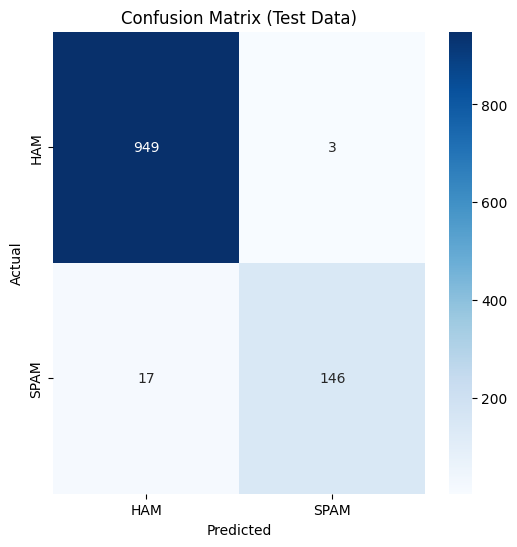

In [78]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test data
y_pred = best_model.predict(x_test)

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTesting Accuracy: {test_accuracy:.2%}")  # e.g., "95.23%"

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["HAM", "SPAM"]))

# Confusion Matrix (visual)
plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["HAM", "SPAM"],
    yticklabels=["HAM", "SPAM"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Data)")
plt.show()